<h1>PyHEP 2020: A Practical Analysis in Coffea</h1>
<p>[TODO: Authors]</p>
<hr />
<h2>Introduction</h2>
<p>This tutorial is intended to be a walkthrough of the foundations of an analysis implemented in Coffea (specifically, single top-Higgs production, https://doi.org/10.1103/PhysRevD.99.092005). We will go through data selection in a columnar regime, how to handle some edge cases, and plot some relevant data. At the end, we will wrap everything together and demonstrate how Coffea can be easily deployed for scaling an analysis up, which is also a prime opportunity to show off a prototype analysis facility being developed by the coffea-casa team.</p>


<h2>Review</h2>
<p>For the purposes of this tutorial, we will load in a sample file used in the analysis, as well as NanoEvents from the Coffea package. A NanoEvents tutorial was given yesterday by Nick Smith, but I will give a quick review of its basics.</p>

In [1]:
try:
    import numpy as np
except ImportError as e:
    !pip install numpy
    import numpy as np

try:
    from coffea.nanoaod import NanoEvents
except ImportError as e:
    !conda install -c conda-forge xrootd --yes
    !pip install coffea
    from coffea.nanoaod import NanoEvents
    
try:
    import numba as nb
except ImportError as e:
    !pip install numba
    import numba as nb

import time

file = "root://xrootd.unl.edu//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root"
events = NanoEvents.from_file(file, entrystop=100000)

<p>Effectively, this loads in "file" into a flat array, "events". We can poke around "events" by looking at the ".columns" attribute, which tells us all of the possible fields we can access.</p>

In [2]:
print(events)
print('\n')
print(events.columns)

[<event 0> <event 1> <event 2> ... <event 99997> <event 99998> <event 99999>]


['IsoTrack', 'fixedGridRhoFastjetCentral', 'GenPart', 'LHEWeight', 'ChsMET', 'PV', 'HLTriggerFirstPath', 'HLTriggerFinalPath', 'Muon', 'luminosityBlock', 'event', 'Photon', 'SoftActivityJetNjets2', 'MET', 'LHE', 'LHEScaleWeight', 'fixedGridRhoFastjetAll', 'Flag', 'SoftActivityJet', 'LHEPdfWeight', 'fixedGridRhoFastjetCentralCalo', 'HTXS', 'genWeight', 'RawMET', 'GenDressedLepton', 'SubGenJetAK8', 'SoftActivityJetHT2', 'btagWeight', 'SV', 'SoftActivityJetNjets10', 'HLT', 'OtherPV', 'Generator', 'run', 'Jet', 'fixedGridRhoFastjetCentralNeutral', 'fixedGridRhoFastjetCentralChargedPileUp', 'SubJet', 'TkMET', 'PuppiMET', 'Tau', 'GenJet', 'GenJetAK8', 'SoftActivityJetHT5', 'TrigObj', 'Pileup', 'L1PreFiringWeight', 'CorrT1METJet', 'FatJet', 'Electron', 'CaloMET', 'SoftActivityJetNjets5', 'PSWeight', 'GenMET', 'LHEReweightingWeight', 'LHEPart', 'GenVisTau', 'L1simulation', 'genTtbarId', 'SoftActivityJetHT10', 'Soft

<p>These fields can be accessed as attributes of the event array. For example, to peek at Muons:</p>

In [3]:
print(events.Muon)
print(events.Muon.size)

[[<Muon 0> <Muon 1>] [] [<Muon 2>] ... [<Muon 100913> <Muon 100914> <Muon 100915> <Muon 100916>] [<Muon 100917>] [<Muon 100918>]]
100000


<p>Notice that events.Muon is a jagged array; an array of subarrays! The number of subarrays is equivalent to the size of the events array. However, each subarray has an arbitrary amount of muons. In total, there are 100918 muons, but still only 100000 subarrays.</p>

<p>The Muon array (and any other column beneath events) also has further depth to it. We can look at its columns just as we did with the events array, and we can access any of them as an attribute of events.Muon:

In [4]:
print(events.Muon.columns)
print('\n')
print(events.Muon.pt)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[48.43083 32.657864] [] [61.244366] ... [49.568356 24.632607 11.763041 3.9598055] [3.946702] [17.98306]]


Now, possibly the most critical component of columnar analysis is the concept of masking. A mask is an array of booleans, which another array can be masked by, thus accepting or rejecting elements of that array based on whether the corresponding mask element is True or False. A basic example below:

In [5]:
data_array = np.array(['a', 'b', 'd', 'c'])
mask_array = np.array([True, True, False, True])

data_array[mask_array]

array(['a', 'b', 'c'], dtype='<U1')

<p>We can generate a mask array with a conditional statement involving a whole array:</p>

In [6]:
muons = events.Muon

print('Unmasked data:')
print(muons.pt)

print('\nMask of data:')
print(muons.pt > 40)

print('\nMasked data:')
print(muons.pt[muons.pt > 40])

Unmasked data:
[[48.43083 32.657864] [] [61.244366] ... [49.568356 24.632607 11.763041 3.9598055] [3.946702] [17.98306]]

Mask of data:
[[True False] [] [True] ... [True False False False] [False] [False]]

Masked data:
[[48.43083] [] [61.244366] ... [49.568356] [] []]


We will employ masking in our analysis to reject leptons and events which do not meet the requirements we desire.

<h2>Lepton Selection</h2>
<p>Let's now begin with some lepton selection, which lends itself towards a simple columnar implementation. From the draft note of the aforementioned analysis:</p>

| Cut                      | Loose        | Tight        |
|--------------------------|--------------|--------------|
| $\eta$ < 2.4             | $\checkmark$ | $\checkmark$ |
| $p_T$                    | > 5 GeV      | > 15 GeV     |
| \|$d_{xy}$\| < 0.05 (cm) | $\checkmark$ | $\checkmark$ |
| \|$d_z$\| < 0.1 (cm)     | $\checkmark$ | $\checkmark$ |
| SIP$_{3D}$ < 8           | $\checkmark$ | $\checkmark$ |
| I$_{mini}$ < 0.4         | $\checkmark$ | $\checkmark$ |
| is Loose Muon            | $\checkmark$ | $\checkmark$ |
| jet CSV                  | -            | < 0.8484     |
| is Medium Muon           | -            | $\checkmark$ |
| tight-charge             | -            | $\checkmark$ |
| lepMVA > 0.90            | -            | $\checkmark$ |

How would we make these cuts with our columnar tools? An easy two-step plan: generate a mask array for each condition, and mask the muon array with it. Of course, we'll also want to split the muon array into two: a loose muon array, and a tight muon array.

<p>The only intermediate step is figuring out which columns you need and how they are structured; I've left in an extra cell if you want to poke at any specific ones.</p>

In [8]:
loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                    (muons.pt > 5) &
                    (np.abs(muons.dxy) < 0.05) &
                    (np.abs(muons.dz) < 0.1) &
                    (muons.sip3d < 8) &
                    (muons.miniPFRelIso_all < 0.4) &
                    (muons.looseId)]
                    # Note that no other cuts are necessary for loose muons!

# To construct the tight selection, we may as well make use of the loose cut, since they overlap.
tight_muons = loose_muons[(loose_muons.pt > 15) &
                         (loose_muons.mediumId) &
                         (loose_muons.mvaTTH > 0.9)]

In [24]:
print(muons.columns)
print('\n')
print(muons.mediumId)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[True True] [] [True] ... [True False False True] [True] [True]]


<p>Let's do the same thing for electrons, which are slightly complicated because some of the cuts fall into a set of two ranges: 0 < |$\eta$| < 1.479 and 1.479 < |$\eta$| < 2.5. These are listed respectively in parentheses: (range 1, range 2).</p>

| Cut                                     | Loose        | Tight        |
|-----------------------------------------|--------------|--------------|
| $\eta$ < 2.5                            | $\checkmark$ | $\checkmark$ |
| $p_T$                                   | > 7 GeV      | > 15 GeV     |
| \|$d_{xy}$\| < 0.05 (cm)                | $\checkmark$ | $\checkmark$ |
| \|$d_z$\| < 0.1 (cm)                    | $\checkmark$ | $\checkmark$ |
| I$_{mini}$ < 0.4                        | $\checkmark$ | $\checkmark$ |
| Number of missing hits                  | < 2          | == 0         |
| tight-charge                            | -            | $\checkmark$ |
| conversion rejection                    | -            | $\checkmark$ |
| lepMVA > 0.90                           | -            | $\checkmark$ |
| MVA ID > (0.0, 0.7)                     | $\checkmark$ | $\checkmark$ |
| $\sigma_{i\eta i\eta}$ < (0.011, 0.030) | -            | $\checkmark$ |
| H/E < (0.10, 0.07)                      | -            | $\checkmark$ |
| -0.05 < 1/E - 1/p < (0.010, 0.005)      | -            | $\checkmark$ |

A cell has been provided, again, for column-prodding purposes.

In [10]:
electrons = events.Electron

loose_electrons = electrons[(np.abs(electrons.eta) < 2.5) &
                           (electrons.pt > 7) &
                           (np.abs(electrons.dxy) < 0.05) &
                           (np.abs(electrons.dz) < 0.1) &
                           (electrons.miniPFRelIso_all < 0.4) &
                           (electrons.lostHits < 2) &
                           # The scary one, the only one with two ranges in loose selection. 
                           (((electrons.mvaFall17V2noIso > 0) & (np.abs(electrons.eta) < 1.479)) |
                            ((electrons.mvaFall17V2noIso > 0.7) & (np.abs(electrons.eta) > 1.479) & (np.abs(electrons.eta) < 2.5)))]

# Again, all tight leptons pass the loose cut, so we may as well cut down on passing the same cuts twice.
tight_electrons = loose_electrons[(loose_electrons.pt > 15) &
                                 (loose_electrons.lostHits == 0) &
                                 (loose_electrons.tightCharge > 0) &
                                 (loose_electrons.convVeto) &
                                 (loose_electrons.mvaTTH > 0.90) &
                                 # Two ranges for sigma_ieie.
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.sieie < 0.011)) | 
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.sieie < 0.03))) &
                                 # Two ranges for H/E
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.hoe < 0.1)) | 
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.hoe < 0.07))) &
                                 # Two ranges for 1/E - 1/p
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.eInvMinusPInv < 0.01) & (loose_electrons.eInvMinusPInv > -0.05)) |
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.eInvMinusPInv < 0.005) & (loose_electrons.eInvMinusPInv > -0.05)))]

In [ ]:
print(events.Electron.columns)
print('\n')
print(events.Electron.lostHits)

<h2>Event Selections</h2>
<p>Okay, now that we've selected some good leptons, let's follow the event selection prescribed in the draft note:</p>

| Both Channels                                                                                              	| Dilepton Channel                              	| Three-Lepton Channel                          	|
|------------------------------------------------------------------------------------------------------------	|-----------------------------------------------	|-----------------------------------------------	|
| No loose leptons with $m_{ll}$ < 12 GeV                                                                    	| Exactly two tight same-sign leptons           	| Exactly three tight leptons                   	|
| One or more jets passing $p_T$ > 25 GeV and \|$\eta$\| < 2.4                                               	| $p_T$ > 25/15 GeV                             	| $p_T$ > 25/15/15 GeV                          	|
| One or more jets failing both the above criterion,<br>AND not qualifying $p_T$ > 40 and \|$\eta$\| > 2.4. 	| No ee events with \|$m_{ee} - m_Z$\| < 10 GeV 	| No OSSF pair with \|$m_{ll} - m_Z$\| < 15 GeV 	|
|                                                                                                            	| Triple charge consistent electrons            	|                                               	|
|                                                                                                            	| Muons with $\Delta p_T / p_T$ < 0.2           	|                                               	|

<p>We reach some limitations of the columnar regime here, as we are forced to deal not with muons and electrons, but with "leptons". We're currently constrained to either looking at electrons or muons, and thus we don't have an easy combined "lepton" object to work with. And there are many ways that the three-lepton requirement, for example, could be met: eee, mumumu, eemu, emumu.</p>

<p>Considering each of these combinations makes a columnar approach a bit more cumbersome. Worse, there's no general solution for dealing with <b>n</b> leptons. In the dilepton channel, there's 3 possible combinations, in the three-lepton, 4, in the n-lepton, n+1. This is hardly ideal; it's certainly, at least, much less pretty than the lepton selection was.</p>  

<p>At this point, I made the decision not to get bogged down in columnar operations, and instead to take a more familiar event-loop-like approach. Before going into details, it's important to understand the structure of our lepton arrays a little more: every jagged array has a ".content" attribute which removes the jaggedness and returns a flat array, and it also has a ".starts" and ".stops" attribute which delineates where a subarray begins and ends.</p>

In [26]:
print('Jagged Array:')
print(electrons.pt)
print('\nFlat Content Array:')
print(electrons.pt.content)
print('\nFlat Starts Array:')
print(electrons.pt.starts)
print('\nFlat Stops Array:')
print(electrons.pt.stops)

Jagged Array:
[[] [84.48751 27.30925] [89.66919 9.768386 6.686062] ... [6.7449427] [7.580601] []]

Flat Content Array:
[84.48751 27.30925 89.66919 ... 95.80427 6.7449427 7.580601]

Flat Starts Array:
[     0      0      2 ... 128335 128336 128337]

Flat Stops Array:
[     0      2      5 ... 128336 128337 128337]


<p>This allows us to deconstruct our electron and muon arrays into their constituent event subarrays, which we can then concatenate together to get a per-event lepton array. We can check whether this lepton array meets our event requirements, and return either a True or a False. By looping through every single event, we can construct a whole array of booleans from this lepton array, which is shaped like the events array, and which will serve as a mask, allowing us to return to a columnar approach.</p>

<p>Okay, that all sounds complicated. Let's implement it for our first requirement in both channels: we don't want any loose leptons with $m_{ll} < 12 GeV$.</p>

In [33]:
from itertools import combinations

# This is a helper function which adds up the mass of two 4-vectors based on their components.
@nb.njit
def massAddition(l1_px, l1_py, l1_pz, l1_E,
                 l2_px, l2_py, l2_pz, l2_E):
    return np.sqrt((l1_E + l2_E)**2 - 
                  ((l1_px + l2_px)**2 + 
                   (l1_py + l2_py)**2 + 
                   (l1_pz + l2_pz)**2))

def looseFilter(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops,
               loose_e_px, loose_e_py, loose_e_pz, loose_e_E,
               loose_mu_px, loose_mu_py, loose_mu_pz, loose_mu_E):
    
    # All events pass by default, if they do not, we turn the 1's to 0's.
    final_mask = np.ones(loose_e_starts.size, dtype=np.bool_)
    
    # With the starts and stops, we can get each event's data per-event, and work with concatenated e's and mu's.
    for e_start, e_stop, mu_start, mu_stop, i in zip(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops, range(0, loose_e_starts.size)):
        event_E = np.concatenate((loose_e_E[e_start:e_stop], loose_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((loose_e_px[e_start:e_stop], loose_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((loose_e_py[e_start:e_stop], loose_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((loose_e_pz[e_start:e_stop], loose_mu_pz[mu_start:mu_stop]))
        # This handles empty events.
        if event_E.size == 0:
            final_mask[i] = 0
        # Generate every pair, check that their combined mass is greater than 12 (if not, change 1 to 0 in mask)
        for combination in np.array(list(combinations(np.argsort(event_E), 2))):
            if 12 > (massAddition(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                           event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]])):
                final_mask[i] = 0
    return final_mask

looseMask = looseFilter(loose_electrons.starts, loose_electrons.stops, loose_muons.starts, loose_muons.stops,
            loose_electrons.x.content, loose_electrons.y.content, loose_electrons.z.content, loose_electrons.energy.content,
            loose_muons.x.content, loose_muons.y.content, loose_muons.z.content, loose_muons.energy.content)

Not strictly columnar, but it's more general, the goal is clearer, and Coffea allows us the flexibility. We handle the dilepton and three-lepton channel selections in similar fashion.

In [13]:
# This is a helper function which determines how far the mass of a pair of leptons is from the Z mass.
@nb.njit()
def massFromZ(l1_px, l1_py, l1_pz, l1_E,
              l2_px, l2_py, l2_pz, l2_E):
    mass_Z = 91.1867
    mass_ll = massAddition(l1_px, l1_py, l1_pz, l1_E,
                           l2_px, l2_py, l2_pz, l2_E)
    return np.abs(mass_ll - mass_Z)

def leptonChannels(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops,
                tight_e_px, tight_e_py, tight_e_pz, tight_e_E,
                tight_mu_px, tight_mu_py, tight_mu_pz, tight_mu_E,
                tight_e_pt, tight_mu_pt, e_charge, e_tightCharge, mu_charge, mu_pterr):
    dilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    trilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    
    for e_start, e_stop, mu_start, mu_stop, i in zip(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops, range(0, tight_e_starts.size)):
        event_pt = np.concatenate((tight_e_pt[e_start:e_stop], tight_mu_pt[mu_start:mu_stop]))
        event_mu_ptErr = mu_pterr[mu_start:mu_stop]
        event_E = np.concatenate((tight_e_E[e_start:e_stop], tight_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((tight_e_px[e_start:e_stop], tight_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((tight_e_py[e_start:e_stop], tight_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((tight_e_pz[e_start:e_stop], tight_mu_pz[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))

        flavor = np.empty(3, dtype=str)
        
        # Events with exactly 2 leptons
        if not (event_pt.size == 2):
            dilepton_mask[i] = 0
        else:
            if not ((event_pt.max() > 25) & (event_pt.min() > 15)):
                dilepton_mask[i] = 0
            if (event_charge[0] != event_charge[1]):
                dilepton_mask[i] = 0
            if ((tight_e_pt[e_start:e_stop].size == 2) & 
                (10 > massFromZ(event_px[0], event_py[0], event_pz[0], event_E[0],
                                event_px[1], event_py[1], event_pz[1], event_E[1]))
               ):
                dilepton_mask[i] = 0
            # Remove events with muons that have pTErr/pT < 0.2
            if ((tight_mu_pt[mu_start:mu_stop].size > 0) & (event_mu_ptErr/tight_mu_pt[mu_start:mu_stop] > 0.2).any()):
                dilepton_mask[i] = 0
            # Remove events with electrons for which tightCharge is not 2: “Tight charge criteria (0:none, 1:isGsfScPixChargeConsistent, 2:isGsfCtfScPixChargeConsistent)”
            #if ((tight_e_pt[e_start:e_stop].size > 0) & (e_tightCharge[e_start:e_stop] != 2).any()):
            #    dilepton_mask[i] = 0
                
        # Events with exactly 3 leptons
        if not (event_pt.size == 3):
            trilepton_mask[i] = 0
        elif not((event_pt.max() > 25) & (event_pt[0] > 15) & (event_pt[1] > 15) & (event_pt[2] > 15)):
            trilepton_mask[i] = 0
        else:
            flavor[0:(e_stop - e_start)] = 'e'
            flavor[(e_stop-e_start):] = 'm'
            for combination in np.array(combinations(np.argsort(event_pt))):
                if ((event_charge[combination[0]] != event_charge[combination[1]]) &
                    (flavor[combination[0]] == flavor[combination[1]]) &
                    (15 > massFromZ(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                                    event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]]))
                   ):
                    trilepton_mask[i] = 0            
    return dilepton_mask, trilepton_mask

(dileptonMask, trileptonMask) = leptonChannels(tight_electrons.starts, tight_electrons.stops, tight_muons.starts, tight_muons.stops,
                                                       tight_electrons.x.content, tight_electrons.y.content, tight_electrons.z.content, tight_electrons.energy.content,
                                                       tight_muons.x.content, tight_muons.y.content, tight_muons.z.content, tight_muons.energy.content,
                                                       tight_electrons.pt.content, tight_muons.pt.content, tight_electrons['charge'].content, tight_electrons['tightCharge'].content, tight_muons['charge'].content, tight_muons['ptErr'].content)

The jet requirements, on the other hand, can be handled in columnar fashion, since we deal only with jets (no cross-lepton business!)

In [14]:
loose_wp = 0.5425
medium_wp = 0.8484
        
jets = events.Jet
    
jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets.pt > 25) &
                  (jets.btagCSVV2 > medium_wp)).sum() >= 1
jetMask_loose = ((((np.abs(jets.eta) < 2.4) & (jets.pt > 25)) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) &
                 (jets.btagCSVV2 <= loose_wp)).sum() >= 1

We now go back to columnar analysis, put all of our masks together, and apply them to our leptons with ease, getting a dilepton and a three-lepton array for each lepton.

In [15]:
dilepton_event = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
trilepton_event = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)

tight_ll_electrons = tight_electrons[dileptonMask]
tight_lll_electrons = tight_electrons[trileptonMask]
tight_ll_muons = tight_muons[dileptonMask]
tight_lll_muons = tight_muons[trileptonMask]

From here, we can break our results naturally into different channels in a columnar fashion. For example, mumu events are simply those where 'tight_ll_muons.counts == 2,' as the dileptonMask guarantees events with 2 leptons, and 2 muons thus implies 0 electrons.

In [16]:
mumu_channel = tight_ll_muons[tight_ll_muons.counts == 2]
ee_channel = tight_ll_electrons[tight_ll_electrons.counts == 2]

<h2>Plotting</h2>
<p>Coffea has a Hist class dedicated to histogramming, which has similar arguments to Matplotlib. We can use this class, again with some minor columnar manipulations, to plot some parameters of interest. Let's stick to the mumu and ee channels for this, since they're already defined.
<p>Let's try something simple: a plot of the pt of the second muon in each event. This'll just involve an array selection.</p>

/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


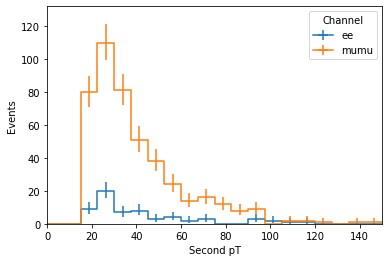

In [17]:
from coffea import hist

second_pt = hist.Hist("Events", 
                      hist.Cat(name='channel', label='Channel'), 
                      hist.Bin(name='pt2', label='Second pT', n_or_arr=20, lo=0, hi=150))

# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_pt2 = mumu_channel.pt[:, 1].flatten()
ee_pt2 = ee_channel.pt[:, 1].flatten()

second_pt.fill(channel='mumu', pt2=mumu_pt2.flatten())
second_pt.fill(channel='ee', pt2=ee_pt2.flatten())

hist.plot1d(second_pt, overlay='channel')

[TODO: A more complicated example?]

<h2>Demo</h2>
<p>To top all of this, Coffea has tools that make scale-out easy. All we do is bundle everything we have done up until now inside of the 'process.ProcessorABC' class. This class allows our analysis to run simply across many files and to deploy on an executor. If you want to test this locally, the futures_executor is the easiest to use. I, however, will be giving a demo of the analysis deployed on a Dask cluster, the details of which were presented by Oksana Shadura earlier this week.</p>

<h2>Acknowledgements</h2>
<p>[TODO: Acknowledgements]</p>